In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # module to split our data into train and test sets
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Import Data

In [44]:
file_name = "customer_churn.xlsx"
df = pd.read_excel(file_name,sheet_name='Telco_Churn')
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,Competitor had better devices


In [45]:
columns = set(df.columns)

for col in columns:

    print(col,': ' ,len(list(df[col].unique())),'\n')

Count :  1 

Zip Code :  1652 

Gender :  2 

Dependents :  2 

Online Security :  3 

Churn Label :  2 

State :  1 

City :  1129 

Internet Service :  3 

Total Charges :  6531 

Online Backup :  3 

Country :  1 

Partner :  2 

Tech Support :  3 

Streaming Movies :  3 

Churn Value :  2 

Multiple Lines :  3 

Contract :  3 

Paperless Billing :  2 

Senior Citizen :  2 

Phone Service :  2 

Payment Method :  4 

Longitude :  1651 

Streaming TV :  3 

Latitude :  1652 

Monthly Charges :  1585 

Tenure Months :  73 

CustomerID :  7043 

Device Protection :  3 

Churn Reason :  21 

Lat Long :  1652 



### Remove Columns

In [46]:
cols_to_remove =  ['Count','Churn Label','Lat Long','Country','State','City']

df.drop(columns = cols_to_remove, inplace = True)

Remove rows with empty values in Total Charges

In [47]:
df = df.drop(df[df['Total Charges'] == ' '].index)
df = df.drop(df[df['Monthly Charges'] == ' '].index)


df.head(1)

,CustomerID,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Reason
0,3668-QPYBK,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,Competitor made better offer


In [48]:
df.dtypes

CustomerID            object
Zip Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Value            int64
Churn Reason          object
dtype: object

In [49]:
df.isnull().mean().round(4) * 100

CustomerID            0.00
Zip Code              0.00
Latitude              0.00
Longitude             0.00
Gender                0.00
Senior Citizen        0.00
Partner               0.00
Dependents            0.00
Tenure Months         0.00
Phone Service         0.00
Multiple Lines        0.00
Internet Service      0.00
Online Security       0.00
Online Backup         0.00
Device Protection     0.00
Tech Support          0.00
Streaming TV          0.00
Streaming Movies      0.00
Contract              0.00
Paperless Billing     0.00
Payment Method        0.00
Monthly Charges       0.00
Total Charges         0.00
Churn Value           0.00
Churn Reason         73.42
dtype: float64

# Data Preparation

### Train Test Split

<li>In this part we split unchurned rows into train and test. This test data will be <i>X_test</i></li>
<li>Then we combine the churned data rows with unchurned train rows to form <i>X_train</i></li>


In [50]:
# split as churned and unchurned datadrames 

churned_df = df.loc[df['Churn Value'] == 1]
unchurned = df.loc[df['Churn Value'] == 0]

print(churned_df.shape)
print(unchurned.shape)

(1869, 25)
(5163, 25)


In [51]:
unchurned_df = unchurned.sample(n = 3000)

df_sampled=pd.concat([unchurned_df,churned_df], ignore_index=True,axis=0)
df_sampled.shape

(4869, 25)

In [52]:
feature_cols = list(df_sampled.columns)
feature_cols.remove('Churn Value')


# split into features and dependent variable
X = df_sampled[feature_cols]
y = df_sampled['Churn Value']

In [60]:
df['Churn Value']=df['Churn Value'].astype(str)

In [61]:
def undersample(df):

    positive_df = df[df['Churn Value']=='1']
    negative_df = df[df['Churn Value']!='1']
    negative_df=negative_df.sample(n=int((positive_df.shape[0])*1.4))

    df_new=pd.concat([positive_df,negative_df],axis=0)

    features=df_new.columns.to_list()
    features.remove('Churn Value')

    X=df_new[features]
    y=df_new['Churn Value']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

    return X_train, X_test, y_train, y_test

    
X_train, X_test, y_train, y_test = undersample(df)
#X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size = 0.2, random_state = 20)
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape) 

X_train shape: (3139, 24)
y_train shape: (3139,)
X_test shape: (1346, 24)
y_test shape: (1346,)


In [62]:

X_unchurned = unchurned_df[feature_cols]
y_unchurned = unchurned_df['Churn Value']

X_unchurned.head(2)

,CustomerID,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Reason
4202,9281-OFDMF,95956,39.937017,-121.058043,Male,Yes,No,No,39,Yes,...,No,No,No,Yes,Month-to-month,No,Electronic check,90.70,3413.25,NaN
5125,5227-JSCFE,95066,37.070177,-122.010077,Male,Yes,Yes,No,71,No,...,Yes,Yes,No,No,Two year,No,Credit card (automatic),46.35,3353.4,NaN


In [63]:
# # Combine X_churned and X_train_uc to produce X_train
# X_train = pd.concat([X_churned,X_train_uc])

# # Combine y_churned and y_train_uc to produce y_train
# y_train = pd.concat([y_churned,y_train_uc])


# X_test = X_test_uc
# y_test = y_test_uc

# print('X_train shape:',X_train.shape)
# print('y_train shape:',y_train.shape)
# print('X_test shape:',X_test.shape)
# print('y_test shape:',y_test.shape)


## Feature Engineering

In [64]:
def feature_eng(df):
        """
        Performs feature Engineering on the data
        i/p:df
        o/p:df
        """

        df['Total Charges'] = df['Total Charges'].astype('float')
        df['Monthly Charges'] = df['Monthly Charges'].astype('float')
        # ohe

        cols_to_ohe = {'Device Protection',
                'Tech Support',
                'Phone Service',
                'Contract',
                'Streaming Movies',
                'Online Security',
                'Dependents',
                'Payment Method',
                'Online Backup',
                'Paperless Billing',
                'Senior Citizen',
                'Multiple Lines',
                'Gender',
                'Partner',
                'Internet Service',
                'Streaming TV'
                }

        for col in cols_to_ohe:

                df = pd.get_dummies(df, columns = [col], drop_first = True, prefix = col)


        return df



## Modelling

Model Function

In [65]:
def create_model(X,y,max_iter=100):

    
    clf=LogReg(max_iter=max_iter).fit(X,y)
    ## Prediction
    

    return clf

In [66]:
X_train.corr()

,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges
Zip Code,1.000000,0.894817,-0.784079,-0.002690,0.014842
Latitude,0.894817,1.000000,-0.876996,0.003992,0.004531
Longitude,-0.784079,-0.876996,1.000000,-0.012236,0.005501
Tenure Months,-0.002690,0.003992,-0.012236,1.000000,0.201120
Monthly Charges,0.014842,0.004531,0.005501,0.201120,1.000000


In [67]:
X_train = feature_eng(X_train.copy())
X_test = feature_eng(X_test.copy())
X_unchurned = feature_eng(X_unchurned.copy())

len(list(X_train.columns))



35

In [68]:
X_train.columns

Index(['CustomerID', 'Zip Code', 'Latitude', 'Longitude', 'Tenure Months',
       'Monthly Charges', 'Total Charges', 'Churn Reason',
       'Online Backup_No internet service', 'Online Backup_Yes',
       'Online Security_No internet service', 'Online Security_Yes',
       'Dependents_Yes', 'Gender_Male', 'Tech Support_No internet service',
       'Tech Support_Yes', 'Partner_Yes',
       'Streaming Movies_No internet service', 'Streaming Movies_Yes',
       'Multiple Lines_No phone service', 'Multiple Lines_Yes',
       'Contract_One year', 'Contract_Two year', 'Paperless Billing_Yes',
       'Senior Citizen_Yes', 'Phone Service_Yes',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check', 'Payment Method_Mailed check',
       'Streaming TV_No internet service', 'Streaming TV_Yes',
       'Internet Service_Fiber optic', 'Internet Service_No',
       'Device Protection_No internet service', 'Device Protection_Yes'],
      dtype='object')

In [69]:
X_train.dtypes

CustomerID                                 object
Zip Code                                    int64
Latitude                                  float64
Longitude                                 float64
Tenure Months                               int64
Monthly Charges                           float64
Total Charges                             float64
Churn Reason                               object
Online Backup_No internet service           uint8
Online Backup_Yes                           uint8
Online Security_No internet service         uint8
Online Security_Yes                         uint8
Dependents_Yes                              uint8
Gender_Male                                 uint8
Tech Support_No internet service            uint8
Tech Support_Yes                            uint8
Partner_Yes                                 uint8
Streaming Movies_No internet service        uint8
Streaming Movies_Yes                        uint8
Multiple Lines_No phone service             uint8


#### Base Model

In [70]:
cols=['Latitude',	
    'Longitude',
    'Tenure Months',
    'Monthly Charges']

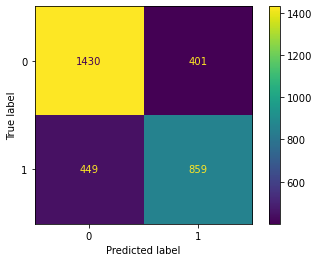

Train score: 0.729213125199108
Test data score: 0.7228826151560178


In [71]:

clf = create_model(X_train[cols],y_train,max_iter=150)

y_pred = clf.predict(X_train[cols])

ConfusionMatrixDisplay.from_predictions(y_train, y_pred) 

plt.show()
print('Train score:',clf.score(X_train[cols],y_train))
print('Test data score:',clf.score(X_test[cols],y_test))

#### Model 2


In [72]:
all_cols = set(X_train.columns)

cols_to_remove = {'Country',
                    'City',
                    'State',
                    'CustomerID',
                    'Zip Code',
                    'Lat Long',
                    'Total Charges',
                    'Internet Service_Fiber optic',
                    'Internet Service_No',
                    'Multiple Lines_No phone service',
                    'Latitude',
                    'Longitude',
                    'Churn Reason'
                    }
cols_new = list(all_cols-cols_to_remove)

cols_new



['Tech Support_Yes',
 'Streaming Movies_Yes',
 'Multiple Lines_Yes',
 'Partner_Yes',
 'Online Backup_Yes',
 'Phone Service_Yes',
 'Streaming Movies_No internet service',
 'Contract_Two year',
 'Online Security_Yes',
 'Paperless Billing_Yes',
 'Online Backup_No internet service',
 'Tech Support_No internet service',
 'Payment Method_Credit card (automatic)',
 'Payment Method_Electronic check',
 'Online Security_No internet service',
 'Senior Citizen_Yes',
 'Dependents_Yes',
 'Streaming TV_No internet service',
 'Device Protection_Yes',
 'Streaming TV_Yes',
 'Payment Method_Mailed check',
 'Gender_Male',
 'Contract_One year',
 'Monthly Charges',
 'Tenure Months',
 'Device Protection_No internet service']

In [73]:
def plot_correlation(corr):



    plt.figure(figsize = (15,12)) # setting the size of the output

    sns.heatmap(corr,
                annot = True,
                linecolor='black',
                center=0,
                vmin=-1,
                vmax=1,
                cmap = sns.diverging_palette(600,600, as_cmap=True),
                fmt='.4g')

    plt.title('Car features and thier correlation') # naming the plot

    #plt.savefig('plot.png', dpi = 300, bbox_inches = 'tight') # saving the chart as a .png – it will be saved in the current working directory

    plt.show()

churn_corr=X_train[cols_new].corr()

# plot_correlation(churn_corr)

Train Data Evaluation

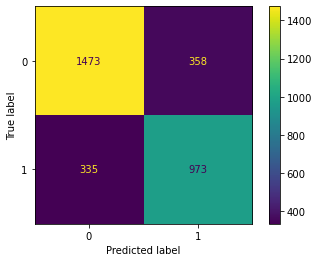

Train score: 0.7792290538388021


In [74]:
clf = create_model(X_train[cols_new],y_train,max_iter=650)



y_pred = clf.predict(X_train[cols_new])

X_train['churn_pred'] = y_pred

ConfusionMatrixDisplay.from_predictions(y_train, y_pred) 

plt.show()
print('Train score:',clf.score(X_train[cols_new],y_train))



Test Data Evaluation

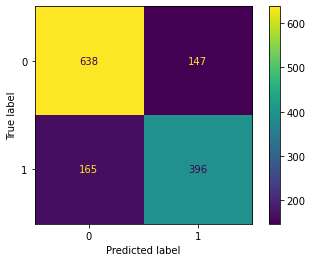

Test data score: 0.7682020802377415


In [75]:
y_pred = clf.predict(X_test[cols_new])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred) 

plt.show()
print('Test data score:',clf.score(X_test[cols_new],y_test))

In [83]:
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       785
           1       0.73      0.71      0.72       561

    accuracy                           0.77      1346
   macro avg       0.76      0.76      0.76      1346
weighted avg       0.77      0.77      0.77      1346



# Find 500 most customers most likely to churn

In [76]:
test_prob = clf.predict_proba(X_unchurned[cols_new]).T[0]
len(test_prob)

3000

### 500 customers more likey to churn

In [77]:
X_unchurned['churn_probability'] = clf.predict_proba(X_unchurned[cols_new]).T[0]
customers = X_unchurned.sort_values(by='churn_probability', axis=0, ascending=False)
customers_500 = list(customers['CustomerID'].head(500))
customers_500

['0784-ZQJZX',
 '1764-VUUMT',
 '9365-CSLBQ',
 '3279-DYZQM',
 '7157-SMCFK',
 '0831-JNISG',
 '4086-WITJG',
 '4277-BWBML',
 '3563-SVYLG',
 '5799-JRCZO',
 '1403-GYAFU',
 '6928-ONTRW',
 '4957-SREEC',
 '1166-PQLGG',
 '0464-WJTKO',
 '0531-XBKMM',
 '9537-JALFH',
 '5346-BZCHP',
 '0902-XKXPN',
 '3996-ZNWYK',
 '3642-BYHDO',
 '8229-BUJHX',
 '8750-QWZAJ',
 '7876-DNYAP',
 '0042-RLHYP',
 '7010-BRBUU',
 '0270-THENM',
 '7673-BQGKU',
 '6980-IMXXE',
 '2607-DHDAK',
 '0562-HKHML',
 '6285-FTQBF',
 '8043-PNYSD',
 '9625-RZFUK',
 '3810-PJUHR',
 '7980-MHFLQ',
 '5854-KSRBJ',
 '0174-QRVVY',
 '6283-GITPX',
 '0480-KYJVA',
 '6253-GNHWH',
 '0394-YONDK',
 '8165-ZJRNM',
 '6963-KQYQB',
 '4821-WQOYN',
 '0402-OAMEN',
 '0613-WUXUM',
 '7064-JHXCE',
 '9337-SRRNI',
 '7399-QHBJS',
 '5884-FBCTL',
 '6976-BWGLQ',
 '7225-IILWY',
 '9114-DPSIA',
 '6485-QXWWE',
 '7711-GQBZC',
 '6855-VLGOS',
 '3261-CQXOL',
 '7558-IMLMT',
 '5902-WBLSE',
 '2626-VEEWG',
 '7729-XBTWX',
 '8711-LOBKY',
 '9769-TSBZE',
 '6857-TKDJV',
 '0988-AADSA',
 '0485-ZBS

## Churn Factors

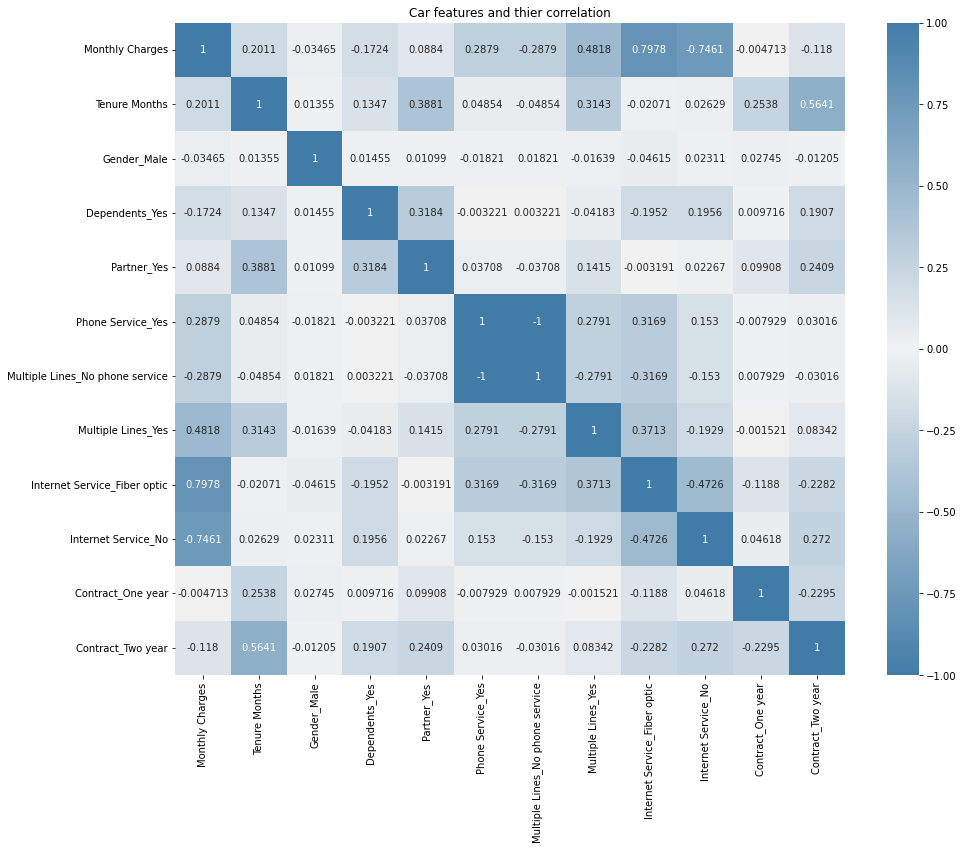

In [78]:
churn_factors = ['Monthly Charges',
                'Tenure Months',
                'Gender_Male',
                'Dependents_Yes',
                'Partner_Yes',
                'Phone Service_Yes', 
                'Multiple Lines_No phone service',
                'Multiple Lines_Yes',
                 'Internet Service_Fiber optic',
                'Internet Service_No',
                 'Contract_One year',
                  'Contract_Two year',
                'churn_pred',
                    ]

churn_corr=X_train[churn_factors].corr()
churn_corr
plot_correlation(churn_corr)

# Random Forest Modelling

In [79]:
y_test.unique()

array(['0', '1'], dtype=object)

In [80]:
rf_cust=['6651-RLGGM','8946-BFWSG','1403-GYAFU',
 '0040-HALCW',
 '9800-OUIGR',
 '8219-VYBVI',
 '7010-BRBUU',
 '6976-BWGLQ',
 '0640-YJTPY',
 '3190-ITQXP',
 '3457-PQBYH',
 '6340-DACFT',
 '4804-NCPET',
 '4979-HPRFL',
 '7634-HLQJR',
 '6762-NSODU',
 '4779-ZGICK',
 '1052-QJIBV',
 '0962-CQPWQ',
 '0902-XKXPN',
 '1830-IPXVJ',
 '1098-KFQEC',
 '1248-DYXUB',
 '5549-ZGHFB',
 '5968-HYJRZ',
 '0402-OAMEN',
 '3088-FVYWK',
 '9365-CSLBQ',
 '6770-UAYGJ',
 '1834-WULEG',
 '8755-OGKNA',
 '3642-BYHDO',
 '6408-WHTEF',
 '0704-VCUMB',
 '9371-BITHB',
 '9950-MTGYX',
 '0301-FIDRB',
 '3913-RDSJZ',
 '2007-QVGAW',
 '9537-JALFH',
 '4443-EMBNA',
 '9415-ZNBSX',
 '3913-FCUUW',
 '5117-ZSMHQ',
 '1293-BSEUN',
 '4674-HGNUA',
 '0784-ZQJZX',
 '5480-XTFFL',
 '1764-VUUMT',
 '8540-ZQGEA',
 '0971-QIFJK',
 '4955-VCWBI',
 '8043-PNYSD',
 '0831-JNISG',
 '7647-GYYKX',
 '4487-ZYJZK',
 '3262-EIDHV',
 '0825-CPPQH',
 '4707-YNOQA',
 '5296-PSYVW',
 '4900-MSOMT',
 '1207-BLKSA',
 '0206-OYVOC',
 '3768-VHXQO',
 '7980-MHFLQ',
 '4962-CHQPW',
 '9067-SQTNS',
 '8194-PEEBY',
 '1089-XZWHH',
 '8434-VGEQQ',
 '9028-LIHRP',
 '7463-IFMQU',
 '9430-NKQLY',
 '3133-PZNSR',
 '1862-QRWPE',
 '2263-SFSQZ',
 '0404-AHASP',
 '2848-YXSMW',
 '9224-VTYID',
 '8779-YIQQA',
 '5627-TVBPP',
 '6892-BOGQE',
 '9710-NJERN',
 '5176-LMJXE',
 '1087-GRUYI',
 '2984-TBYKU',
 '7113-HIPFI',
 '8915-NNTRC',
 '5743-KHMNA',
 '4644-OBGFZ',
 '3129-AAQOU',
 '3470-OBUET',
 '1776-SPBWV',
 '9087-EYCPR',
 '9227-YBAXE',
 '6199-IPCAO',
 '2885-HIJDH',
 '1767-CJKBA',
 '2097-YVPKN',
 '8701-DGLVH',
 '8882-TLVRW',
 '2696-RZVZW',
 '3873-WOSBC',
 '8450-LUGUK',
 '0675-NCDYU',
 '8232-UTFOZ',
 '8645-KOMJQ',
 '5647-URDKA',
 '5982-XMDEX',
 '3148-AOIQT',
 '3258-ZKPAI',
 '6134-KWTBV',
 '5751-USDBL',
 '2908-WGAXL',
 '5177-RVZNU',
 '4973-MGTON',
 '8807-OPMBM',
 '6625-FLENO',
 '5442-PPTJY',
 '4163-NCJAK',
 '8512-WIWYV',
 '6164-HAQTX',
 '8966-SNIZF',
 '7643-RCHXS',
 '0531-XBKMM',
 '2256-YLYLP',
 '3889-VWBID',
 '1934-MKPXS',
 '7305-ZWMAJ',
 '1395-WSWXR',
 '5148-HKFIR',
 '6139-ZZRBQ',
 '4933-BSAIP',
 '1775-KWJKQ',
 '5067-WJEUN',
 '6265-FRMTQ',
 '3982-JGSFD',
 '2068-WWXQZ',
 '6867-ACCZI',
 '5248-YGIJN',
 '4565-NLZBV',
 '6384-VMJHP',
 '7710-JSYOA',
 '0757-WCUUZ',
 '5201-CBWYG',
 '5707-ZMDJP',
 '9624-EGDEQ',
 '0608-JDVEC',
 '8670-MEFCP',
 '0827-ITJPH',
 '4795-UXVCJ',
 '1982-FEBTD',
 '9739-JLPQJ',
 '2749-CTKAJ',
 '2005-DWQZJ',
 '0020-INWCK',
 '5231-FIQPA',
 '5821-MMEIL',
 '8857-CUPFQ',
 '6345-FZOQH',
 '5380-XPJNZ',
 '9435-JMLSX',
 '2333-KWEWW',
 '3525-DVKFN',
 '1755-FZQEC',
 '7328-OWMOM',
 '1116-FRYVH',
 '5214-CHIWJ',
 '6100-FJZDG',
 '9548-LERKT',
 '0129-QMPDR',
 '6332-FBZRI',
 '1945-XISKS',
 '3704-IEAXF',
 '5788-YPOEG',
 '5980-BDHPY',
 '2560-WBWXF',
 '9108-EQPNQ',
 '2995-YWTCD',
 '1240-HCBOH',
 '5996-EBTKM',
 '1682-VCOIO',
 '6447-EGDIV',
 '0621-CXBKL',
 '7190-XHTWJ',
 '3486-NPGST',
 '7765-LWVVH',
 '9531-NSBMR',
 '8901-UPRHR',
 '5469-NUJUR',
 '8046-DNVTL',
 '3230-JCNZS',
 '1335-MXCSE',
 '2235-EZAIK',
 '4573-JKNAE',
 '3646-ITDGM',
 '0401-WDBXM',
 '9297-EONCV',
 '5847-MXBEO',
 '9479-HYNYL',
 '3392-EHMNK',
 '1599-MMYRQ',
 '3301-VKTGC',
 '8510-TMWYB',
 '1930-BZLHI',
 '2599-CIPQE',
 '7416-CKTEP',
 '1015-JPFYW',
 '7665-NKLAV',
 '8780-YRMTT',
 '6368-TZZDT',
 '3795-CAWEX',
 '4980-URKXC',
 '1222-KJNZD',
 '9764-REAFF',
 '0042-JVWOJ',
 '6609-MXJHJ',
 '6445-TNRXS',
 '1657-DYMBM',
 '2146-EGVDT',
 '8097-OMULG',
 '6418-PIQSP',
 '3938-YFPXD',
 '9499-XPZXM',
 '4537-CIBHB',
 '4194-FJARJ',
 '6614-YOLAC',
 '2587-YNLES',
 '2773-MADBQ',
 '5696-EXCYS',
 '9500-IWPXQ',
 '9500-WBGRP',
 '1686-STUHN',
 '3617-XLSGQ',
 '9814-AOUDH',
 '7319-ZNRTR',
 '8565-WUXZU',
 '5930-GBIWP',
 '5063-IUOKK',
 '2796-NNUFI',
 '6217-KDYWC',
 '5126-RCXYW',
 '6122-EFVKN',
 '2205-LPVGL',
 '5614-DNZCE',
 '9385-NXKDA',
 '5485-ITNPC',
 '0123-CRBRT',
 '1492-KGETH',
 '0277-ORXQS',
 '5055-BRMNE',
 '5862-BRIXZ',
 '0519-DRGTI',
 '6434-TTGJP',
 '1573-LGXBA',
 '0017-DINOC',
 '7137-NAXML',
 '8592-PLTMQ',
 '2904-GGUAZ',
 '5730-DBDSI',
 '5656-JAMLX',
 '1302-TPUBN',
 '7636-PEPNS',
 '9769-TSBZE',
 '9397-TZSHA',
 '0960-HUWBM',
 '1439-LCGVL',
 '3967-KXAPS',
 '3200-MNQTF',
 '3948-KXDUF',
 '2990-IAJSV',
 '1414-YADCW',
 '8106-GWQOK',
 '7607-QKKTJ',
 '7696-AMHOD',
 '3552-CTCYF',
 '3766-EJLFL',
 '5816-JMLGY',
 '8457-XIGKN',
 '7432-FFVAR',
 '4654-ULTTN',
 '3021-VLNRJ',
 '7605-BDWDC',
 '4178-EGMON',
 '4737-HOBAX',
 '9639-BUJXT',
 '6625-IUTTT',
 '3026-ATZYV',
 '0559-CKHUS',
 '2790-XUYMV',
 '1139-WUOAH',
 '3423-HHXAO',
 '5232-NXPAY',
 '0114-IGABW',
 '7109-CQYUZ',
 '0379-DJQHR',
 '9746-MDMBK',
 '8958-JPTRR',
 '6616-AALSR',
 '4671-VJLCL',
 '9560-BBZXK',
 '9938-TKDGL',
 '0221-NAUXK',
 '6103-LIANB',
 '8859-AXJZP',
 '8390-FESFV',
 '6650-BWFRT',
 '4950-HKQTE',
 '3719-TDVQB',
 '6556-DBKZF',
 '8328-SKJNO',
 '7233-PAHHL',
 '8690-UPCZI',
 '4295-YURET',
 '1133-KXCGE',
 '1345-ZUKID',
 '8809-XKHMD',
 '4102-HLENU',
 '4933-IKULF',
 '1051-EQPZR',
 '9451-WLYRI',
 '8871-JLMHM',
 '9150-KPBJQ',
 '5197-PYEPU',
 '3721-CNZHX',
 '5260-UMPWX',
 '4994-OBRSZ',
 '9313-QOLTZ',
 '6050-IJRHS',
 '0014-BMAQU',
 '2788-CJQAQ',
 '0513-RBGPE',
 '5062-CJJKH',
 '2192-OZITF',
 '8433-WPJTV',
 '9978-HYCIN',
 '1297-VQDRP',
 '9715-SBVSU',
 '2990-OGYTD',
 '5356-KZCKT',
 '4359-INNWN',
 '0945-TSONX',
 '0602-DDUML',
 '5310-NOOVA',
 '7407-SUJIZ',
 '4849-PYRLQ',
 '8241-JUIQO',
 '0731-EBJQB',
 '0916-KNFAJ',
 '4531-AUZNK',
 '2521-NPUZR',
 '5762-TJXGK',
 '0383-CLDDA',
 '7047-YXDMZ',
 '0253-ZTEOB',
 '1470-PSXNM',
 '5642-MHDQT',
 '9675-ICXCT',
 '6904-JLBGY',
 '9766-HGEDE',
 '3530-VWVGU',
 '2400-XIWIO',
 '3669-WHAFY',
 '5446-DKWYW',
 '8076-FEZKJ',
 '8573-JGCZW',
 '6248-TKCQV',
 '4355-CVPVS',
 '2171-UDMFD',
 '5150-LJNSR',
 '4376-KFVRS',
 '2040-LDIWQ',
 '6421-SZVEM',
 '4648-YPBTM',
 '7623-HKYRK',
 '2243-FNMMI',
 '9677-AVKED',
 '9419-IPPBE',
 '4851-BQDNX',
 '0230-UBYPQ',
 '7138-GIRSH',
 '3258-SYSWS',
 '6339-TBELP',
 '1480-BKXGA',
 '7609-YBPXG',
 '6463-MVYRY',
 '1061-PNTHC',
 '6152-ONASV',
 '9844-FELAJ',
 '5837-LXSDN',
 '7136-IHZJA',
 '2724-FJDYW',
 '7520-HQWJU',
 '7163-OCEQI',
 '2926-JEJJC',
 '5914-XRFQB',
 '8461-EFQYM',
 '7691-KGKGP',
 '0788-DXBFY',
 '9467-ROOLM',
 '5995-LFTLE',
 '5183-KLYEM',
 '2088-IEBAU',
 '0979-MOZQI',
 '2696-ECXKC',
 '5125-CNDSP',
 '2302-OUZXB',
 '0254-FNMCI',
 '6114-TCFID',
 '2233-TXSIU',
 '9867-NNXLC',
 '9968-FFVVH',
 '2096-XOTMO',
 '4713-ZBURT',
 '8263-QMNTJ',
 '0536-BGFMZ',
 '6388-TABGU',
 '9070-BCKQP',
 '1684-FLBGS',
 '1525-LNLOJ',
 '4213-HKBJO',
 '2739-CCZMB',
 '5619-XZZKR',
 '4694-PHWFW',
 '4670-TABXH',
 '0516-QREYC',
 '1163-ONYEY',
 '2933-XEUJM',
 '9432-RUVSL',
 '8439-LTUGF',
 '2958-NHPPS',
 '7449-HVPIV',
 '0285-INHLN',
 '7639-LIAYI',
 '9127-QRZMH',
 '2578-JQPHZ',
 '6668-CNMFP',
 '1271-UODNO',
 '7954-MLBUN',
 '4712-UYOOI',
 '5693-PIPCS',
 '0305-SQECB',
 '3128-YOVTD',
 '8033-ATFAS',
 '9803-FTJCG',
 '0455-ENTCR',
 '8570-KLJYJ',
 '9351-HXDMR',
 '0907-HQNTS',
 '3012-VFFMN',
 '4472-VESGY',
 '6543-JXSOO',
 '1735-XMJVH',
 '6974-DAFLI',
 '4657-FWVFY',
 '5393-HJZSM',
 '6682-VCIXC',
 '5846-QFDFI',
 '6308-CQRBU',
 '9495-SKLKD',
 '5855-EIBDE',
 '0813-TAXXS',
 '8042-RNLKO',
 '2039-JONDJ',
 '3061-BCKYI',
 '8942-DBMHZ',
 '5274-XHAKY',
 '0292-WEGCH',
 '9796-MVYXX',
 '4686-GEFRM',
 '2959-EEXWB',
 '5414-OFQCB',
 '3161-GETRM',
 '6048-UWKAL',
 '6257-DTAYD',
 '3518-FSTWG',
 '7148-XZPHA',
 '9362-MWODR',
 '5712-VBOXD',
 '8329-GWVPJ',
 '3541-ZNUHK',
 '1755-RMCXH',
 '9586-JGQKH',
 '1785-BPHTP',
 '7976-CICYS',
 '7426-WEIJX',
 '3716-LRGXK',
 '8404-VLQFB',
 '0913-XWSCN',
 '5977-CKHON',
 '5294-DMSFH',
 '4854-SSLTN',
 '6353-BRMMA',
 '8348-JLBUG',
 '0620-XEFWH',
 '8378-LKJAF',
 '5954-BDFSG',
 '9670-BPNXF',
 '6121-TNHBO',
 '0128-MKWSG']

In [81]:
lr_cust = ['0784-ZQJZX',
 '3279-DYZQM',
 '0831-JNISG',
 '6928-ONTRW',
 '1166-PQLGG',
 '3173-WSSUE',
 '1052-QJIBV',
 '4086-WITJG',
 '0464-WJTKO',
 '4277-BWBML',
 '0794-YVSGE',
 '2804-ETQDK',
 '4817-KEQSP',
 '3642-BYHDO',
 '0264-CNITK',
 '0640-YJTPY',
 '1403-GYAFU',
 '8229-BUJHX',
 '3996-ZNWYK',
 '4957-SREEC',
 '1764-VUUMT',
 '0042-RLHYP',
 '9537-JALFH',
 '6980-IMXXE',
 '3563-SVYLG',
 '0902-XKXPN',
 '9365-CSLBQ',
 '3678-MNGZX',
 '7157-SMCFK',
 '9800-OUIGR',
 '8043-PNYSD',
 '7980-MHFLQ',
 '7113-HIPFI',
 '1293-BSEUN',
 '0480-KYJVA',
 '7010-BRBUU',
 '6963-KQYQB',
 '0613-WUXUM',
 '8165-ZJRNM',
 '1555-HAPSU',
 '6181-AXXYF',
 '2607-DHDAK',
 '4821-WQOYN',
 '0402-OAMEN',
 '7684-XSZIY',
 '3810-PJUHR',
 '5854-KSRBJ',
 '4193-IBKSW',
 '5884-FBCTL',
 '6976-BWGLQ',
 '6585-WCEWR',
 '1830-IPXVJ',
 '2236-HILPA',
 '0174-QRVVY',
 '7711-GQBZC',
 '2718-YSKCS',
 '0962-CQPWQ',
 '8711-LOBKY',
 '7268-WNTCP',
 '0394-YONDK',
 '3261-CQXOL',
 '8917-SZTTJ',
 '8164-OCKUJ',
 '1299-AURJA',
 '6253-GNHWH',
 '4195-PNGZS',
 '3777-XROBG',
 '7729-XBTWX',
 '7558-IMLMT',
 '2007-QVGAW',
 '6651-RLGGM',
 '3457-PQBYH',
 '7169-YWAMK',
 '9574-BOSMD',
 '6857-TKDJV',
 '8755-OGKNA',
 '0485-ZBSLN',
 '1098-KFQEC',
 '6734-JDTTV',
 '8946-BFWSG',
 '2075-PUEPR',
 '9565-AXSMR',
 '9371-BITHB',
 '9173-IVZVP',
 '8780-IHCRN',
 '7643-RCHXS',
 '0040-HALCW',
 '8882-TLVRW',
 '9430-NKQLY',
 '7860-UXCRM',
 '0531-XBKMM',
 '7293-LSCDV',
 '6582-PLFUU',
 '4625-XMOYM',
 '9257-AZMTZ',
 '0988-AADSA',
 '4900-MSOMT',
 '3359-DSRKA',
 '2230-XTUWL',
 '0562-FGDCR',
 '3511-BFTJW',
 '6340-DACFT',
 '3913-FCUUW',
 '2314-TNDJQ',
 '7608-RGIRO',
 '4534-WGCIR',
 '0386-CWRGM',
 '1814-WFGVS',
 '8395-ETZKQ',
 '7634-HLQJR',
 '4742-TXUEX',
 '6762-NSODU',
 '9769-TSBZE',
 '7242-EDTYC',
 '0508-SQWPL',
 '4979-HPRFL',
 '1207-BLKSA',
 '9975-GPKZU',
 '5970-GHJAW',
 '6518-PPLMZ',
 '6897-RWMUB',
 '0463-TXOAK',
 '2799-TSLAG',
 '3190-ITQXP',
 '1248-DYXUB',
 '8922-NPKBJ',
 '0238-WHBIQ',
 '3470-OBUET',
 '5196-WPYOW',
 '8215-NGSPE',
 '7647-GYYKX',
 '1468-DEFNC',
 '3088-FVYWK',
 '4674-HGNUA',
 '4636-TVXVG',
 '5067-WJEUN',
 '5549-ZGHFB',
 '8626-XHBIE',
 '5117-ZSMHQ',
 '1106-HRLKZ',
 '8690-ZVLCL',
 '5115-GZDEL',
 '4779-ZGICK',
 '3889-VWBID',
 '3262-EIDHV',
 '6770-UAYGJ',
 '4302-ZYFEL',
 '0244-LGNFY',
 '9823-EALYC',
 '5795-BKOYE',
 '2378-YIZKA',
 '5968-HYJRZ',
 '7009-PCARS',
 '1027-LKKQQ',
 '9593-CVZKR',
 '0206-OYVOC',
 '0769-MURVM',
 '6439-PKTRR',
 '4915-BFSXL',
 '4644-OBGFZ',
 '8597-CTXVJ',
 '5296-BFCYD',
 '0506-YLVKJ',
 '6096-EGVTU',
 '2908-WGAXL',
 '7601-GNDYK',
 '6408-WHTEF',
 '5845-BZZIB',
 '7321-KKSDU',
 '5939-SXWHM',
 '7696-CFTAT',
 '5320-BRKGK',
 '8807-OPMBM',
 '9028-LIHRP',
 '2888-ADFAO',
 '2560-QTSBS',
 '3120-FAZKD',
 '2642-MAWLJ',
 '2885-HIJDH',
 '7018-FPXHH',
 '8249-THVEC',
 '4194-FJARJ',
 '8219-VYBVI',
 '3227-WLKLI',
 '2821-WARNZ',
 '5135-RDDQL',
 '3950-VPYJB',
 '7872-BAAZR',
 '2263-SFSQZ',
 '2580-ATZSQ',
 '5201-CBWYG',
 '1599-EAHXY',
 '6656-GULJQ',
 '5338-YHWYT',
 '4641-FROLU',
 '9415-ZNBSX',
 '1492-KGETH',
 '4827-DPADN',
 '6122-LJADA',
 '1270-XKUCC',
 '1335-MXCSE',
 '5248-RPYWW',
 '5480-XTFFL',
 '1116-FRYVH',
 '0301-FIDRB',
 '9443-JUBUO',
 '5707-ZMDJP',
 '0625-AFOHS',
 '9348-ROUAI',
 '9418-RUKPH',
 '3704-IEAXF',
 '3472-QPRCH',
 '8577-QSOCG',
 '8902-ZEOVF',
 '2256-YLYLP',
 '5360-XGYAZ',
 '7340-KEFQE',
 '4609-KNNWG',
 '1839-FBNFR',
 '9055-MOJJJ',
 '4632-XJMEX',
 '2599-CIPQE',
 '1930-QPBVZ',
 '2160-GPFXD',
 '3727-OVPRY',
 '6332-FBZRI',
 '9385-EHGDO',
 '2725-IWWBA',
 '7267-FRMJW',
 '2661-GKBTK',
 '7602-DBTOU',
 '8966-KZXXA',
 '5996-EBTKM',
 '4955-VCWBI',
 '0567-XRHCU',
 '8173-RXAYP',
 '2193-SFWQW',
 '5787-KXGIY',
 '2848-YXSMW',
 '8232-UTFOZ',
 '0404-AHASP',
 '8645-KOMJQ',
 '0825-CPPQH',
 '9227-YBAXE',
 '1927-QEWMY',
 '5751-USDBL',
 '4518-FZBSX',
 '7463-IFMQU',
 '5453-YBTWV',
 '4896-CPRPF',
 '6345-FZOQH',
 '9067-SQTNS',
 '5848-FHRFC',
 '1635-HDGFT',
 '2545-LXYVJ',
 '5774-QPLTF',
 '5249-QYHEX',
 '8966-SNIZF',
 '8619-IJNDK',
 '0505-SPOOW',
 '2616-FLVQC',
 '5146-YYFRZ',
 '5322-ZSMZY',
 '1945-XISKS',
 '1302-TPUBN',
 '0298-XACET',
 '7216-KAOID',
 '4295-YURET',
 '5730-DBDSI',
 '2984-RGEYA',
 '1223-UNPKS',
 '4056-QHXHZ',
 '0739-UUAJR',
 '8999-EXMNO',
 '5177-RVZNU',
 '4804-NCPET',
 '6519-ZHPXP',
 '6199-IPCAO',
 '1172-VIYBP',
 '7973-DZRKH',
 '4487-ZYJZK',
 '8544-JNBOX',
 '5126-RCXYW',
 '7606-BPHHN',
 '5397-NSKQG',
 '2040-XBAVJ',
 '8207-DMRVL',
 '2984-TBYKU',
 '9945-PSVIP',
 '1177-XZBJL',
 '0654-PQKDW',
 '8857-CUPFQ',
 '9500-WBGRP',
 '0277-ORXQS',
 '8092-NLTGF',
 '9950-MTGYX',
 '8450-LUGUK',
 '5322-TEUJK',
 '7161-DFHUF',
 '5656-JAMLX',
 '7665-NKLAV',
 '0057-QBUQH',
 '9739-JLPQJ',
 '5788-YPOEG',
 '6484-LATFU',
 '6696-YDAYZ',
 '8774-GSBUN',
 '4312-KFRXN',
 '7473-ZBDSN',
 '3133-PZNSR',
 '8097-OMULG',
 '1552-CZCLL',
 '3896-ZVNET',
 '1089-XZWHH',
 '2664-XJZNO',
 '9397-TZSHA',
 '5743-KHMNA',
 '3389-KTRXV',
 '0757-WCUUZ',
 '1403-LKLIK',
 '4836-WNFNO',
 '8749-TZYEC',
 '7114-AEOZE',
 '8510-TMWYB',
 '4962-CHQPW',
 '1757-TCATG',
 '4293-ETKAP',
 '9084-OAYKL',
 '2808-CHTDM',
 '2137-DQMEV',
 '0854-UYHZD',
 '2550-AEVRU',
 '1960-UOTYM',
 '7471-MQPOS',
 '2509-TFPJU',
 '0071-NDAFP',
 '4573-JKNAE',
 '1767-CJKBA',
 '4443-EMBNA',
 '8735-SDUFN',
 '0704-VCUMB',
 '9359-JANWS',
 '1843-TLSGD',
 '6556-DBKZF',
 '5442-PPTJY',
 '6772-WFQRD',
 '3696-DFHHB',
 '8659-IOOPU',
 '8434-VGEQQ',
 '1131-QQZEB',
 '6892-BOGQE',
 '2097-YVPKN',
 '9764-REAFF',
 '7493-GVFIO',
 '6609-MXJHJ',
 '2146-EGVDT',
 '7452-FOLON',
 '1635-NZATJ',
 '5208-FVQKB',
 '0971-QIFJK',
 '0621-CXBKL',
 '5583-EJXRD',
 '6901-GOGZG',
 '3836-FZSDJ',
 '3520-FJGCV',
 '1063-DHQJF',
 '2228-BZDEE',
 '6625-FLENO',
 '3646-ITDGM',
 '1032-MAELW',
 '6522-OIQSX',
 '3392-EHMNK',
 '2696-RZVZW',
 '1494-EJZDW',
 '5849-ASHZJ',
 '9802-CAQUT',
 '9953-ZMKSM',
 '3118-UHVVQ',
 '3352-RICWQ',
 '2632-IVXVF',
 '3948-KXDUF',
 '6384-VMJHP',
 '3768-VHXQO',
 '0064-SUDOG',
 '3129-AAQOU',
 '0266-GMEAO',
 '3021-VLNRJ',
 '2005-DWQZJ',
 '9993-LHIEB',
 '9224-VTYID',
 '5627-TVBPP',
 '3870-SPZSI',
 '3873-WOSBC',
 '9814-AOUDH',
 '5647-URDKA',
 '2516-XSJKX',
 '5982-XMDEX',
 '6134-KWTBV',
 '9801-NOSHQ',
 '3230-JCNZS',
 '5821-MMEIL',
 '0224-NIJLP',
 '3717-FDJFU',
 '5472-CVMDX',
 '3913-RDSJZ',
 '9777-IQHWP',
 '9499-XPZXM',
 '8314-HTWVE',
 '0675-NCDYU',
 '9087-EYCPR',
 '2675-IJRGJ',
 '8701-DGLVH',
 '5766-FTRTS',
 '9625-QNLUX',
 '0017-IUDMW',
 '6139-ZZRBQ',
 '8915-NNTRC',
 '3812-LRZIR',
 '8480-PPONV',
 '5334-AFQJB',
 '3027-YNWZU',
 '1051-EQPZR',
 '4636-OLWOE',
 '8606-CIQUL',
 '2587-YNLES',
 '8039-ACLPL',
 '7337-CINUD',
 '6061-GWWAV',
 '3258-ZKPAI',
 '3200-MNQTF',
 '3882-IYOIJ',
 '2176-OSJUV',
 '8194-PEEBY',
 '8540-ZQGEA',
 '2606-PKWJB',
 '6917-FIJHC',
 '2817-LVCPP',
 '2223-GDSHL',
 '8466-PZBLH',
 '7636-PEPNS',
 '5095-ETBRJ',
 '1834-WULEG',
 '8883-ANODQ',
 '3810-DVDQQ',
 '6734-PSBAW',
 '5375-XLDOF',
 '5965-GGPRW',
 '2138-VFAPZ',
 '3795-CAWEX',
 '3212-KXOCR',
 '2878-DHMIN',
 '2632-TACXW',
 '0885-HMGPY',
 '1657-DYMBM',
 '5296-PSYVW',
 '5055-BRMNE',
 '7998-WNZEM',
 '9964-WBQDJ',
 '6217-KDYWC',
 '3612-YVGSJ',
 '4807-IZYOZ',
 '8361-LBRDI',
 '0281-CNTZX',
 '2235-EZAIK',
 '7569-NMZYQ',
 '1407-DIGZV',
 '4378-MYPGO',
 '9091-WTUUY',
 '1080-BWSYE',
 '2560-WBWXF',
 '6445-TNRXS',
 '1240-HCBOH',
 '5915-ANOEI',
 '0804-YGEQV',
 '7860-KSUGX',
 '5529-GIBVH',
 '4632-PAOYU',
 '1776-SPBWV',
 '9178-JHUVJ',
 '4530-NDRKU',
 '4994-OBRSZ',
 '4565-NLZBV',
 '8587-XYZSF',
 '3617-XLSGQ',
 '1955-IBMMB',
 '2405-LBMUW',
 '7710-JSYOA',
 '2650-GYRYL',
 '6368-TZZDT',
 '1741-WTPON',
 '2452-MRMZF',
 '1354-YZFNB',
 '9867-XOBQA',
 '9640-ZSLDC',
 '8779-YIQQA',
 '1431-AIDJQ',
 '8259-DZLIZ',
 '7898-PDWQE',
 '6695-FRVEC',
 '9500-IWPXQ']

In [82]:
lr_cust = set(lr_cust)
rf_cust=set(rf_cust)

len(lr_cust.intersection(rf_cust))

181